<a href="https://colab.research.google.com/github/CristianViSa/TFM/blob/main/tfm_limpieza_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import datetime
import time
import keras.backend as K
import math

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Bidirectional, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import auc, roc_curve, auc, mean_squared_error
from matplotlib import pyplot as plt
from numpy import concatenate

In [2]:
full_data_path = "/content/drive/MyDrive/datos_web/otros/test3.csv"
ordered_data_path = "/content/drive/MyDrive/datos_web/otros/cleaned_ordered.csv"

ordered_data_path_2 = "/content/drive/MyDrive/datos_web/otros/cleaned_ordered_2.csv"
final_data_path = "/content/drive/MyDrive/datos_web/otros/final_data.csv"

test_clean_data_path = "/content/drive/MyDrive/datos_web/otros/test_clean_data.csv"
test_clean_data_path_2 = "/content/drive/MyDrive/datos_web/otros/test_clean_data_2.csv"
test_clean_data_path_full = "/content/drive/MyDrive/datos_web/otros/test_clean_data_full.csv"


test_cleaned_full_path = "/content/drive/MyDrive/datos_web/otros/full_cleaned.csv"

to_show = "/content/drive/MyDrive/datos_web/otros/to_show.csv"

In [ ]:
df = pd.read_csv(full_data_path)
print(df)

In [4]:
# Combina la fecha y la hora para tener todo en un unico campo
fechas = list(set(df['fecha'].values))
#df['fecha'] = pd.to_datetime(df['fecha'], format="%d/%m/%Y")             # Para el otro fichero
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m-%d")
df['fecha'] = df['fecha'].dt.date
df['hora'] = pd.to_datetime(df['hora'], format="%H:%M:%S")
df['hora'] = df['hora'].dt.time
dates = []
for i in range(len(df['fecha'])):
  combined = datetime.datetime.combine(df['fecha'][i], df['hora'][i])
  dates.append(combined)

df['dates'] = dates

In [5]:
fechas.sort()
# Para empezar el 15/03 y acabar el 20/06
fechas = fechas[34:-11]

In [6]:
# Pone la columna de coches al final del dataframe
coches = df['coches']
df = df.drop('coches', axis=1)
df.insert(len(df.columns), "coches", coches )
# Ordena por fecha y ATA
df.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
new_df = df.copy()

In [7]:
data = new_df.copy()
data.set_index(pd.to_datetime(data.dates.values), inplace=True)
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
data = data.loc["2021-03-15 00:00:00":"2021-06-30 23:00:00"]

In [8]:
def plot_series(series):
  show = series[series.ATA=="A71"]
  part1 = show.loc["2021-03-15 00:00:00":"2021-05-15 23:00:00"]
  part2 = show.loc["2021-05-16 00:00:00":"2021-06-20 23:00:00"]
  plt.rcParams.update({'font.size': 17}) # must set in top
  fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
  ax.set_ylabel("Vehículos/Hora")
  ax = part1['coches'].plot(figsize=(26,5))
  
  fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
  ax.set_ylabel("Vehículos/Hora")
  ax = part2['coches'].plot(figsize=(26,5))

                     ATA       barrio  ...               dates  coches
2021-03-15 00:00:00  A71  l olivereta  ... 2021-03-15 00:00:00   168.0
2021-03-15 00:15:00  A71  l olivereta  ... 2021-03-15 00:15:00   210.0
2021-03-15 00:30:00  A71  l olivereta  ... 2021-03-15 00:30:00   210.0
2021-03-15 00:45:00  A71  l olivereta  ... 2021-03-15 00:45:00   210.0
2021-03-15 01:00:00  A71  l olivereta  ... 2021-03-15 01:00:00   210.0
...                  ...          ...  ...                 ...     ...
2021-06-30 22:00:00  A71  l olivereta  ... 2021-06-30 22:00:00  1845.0
2021-06-30 22:15:00  A71  l olivereta  ... 2021-06-30 22:15:00  1458.0
2021-06-30 22:30:00  A71  l olivereta  ... 2021-06-30 22:30:00  1746.0
2021-06-30 22:45:00  A71  l olivereta  ... 2021-06-30 22:45:00  1440.0
2021-06-30 23:00:00  A71  l olivereta  ... 2021-06-30 23:00:00  1278.0

[9985 rows x 15 columns]


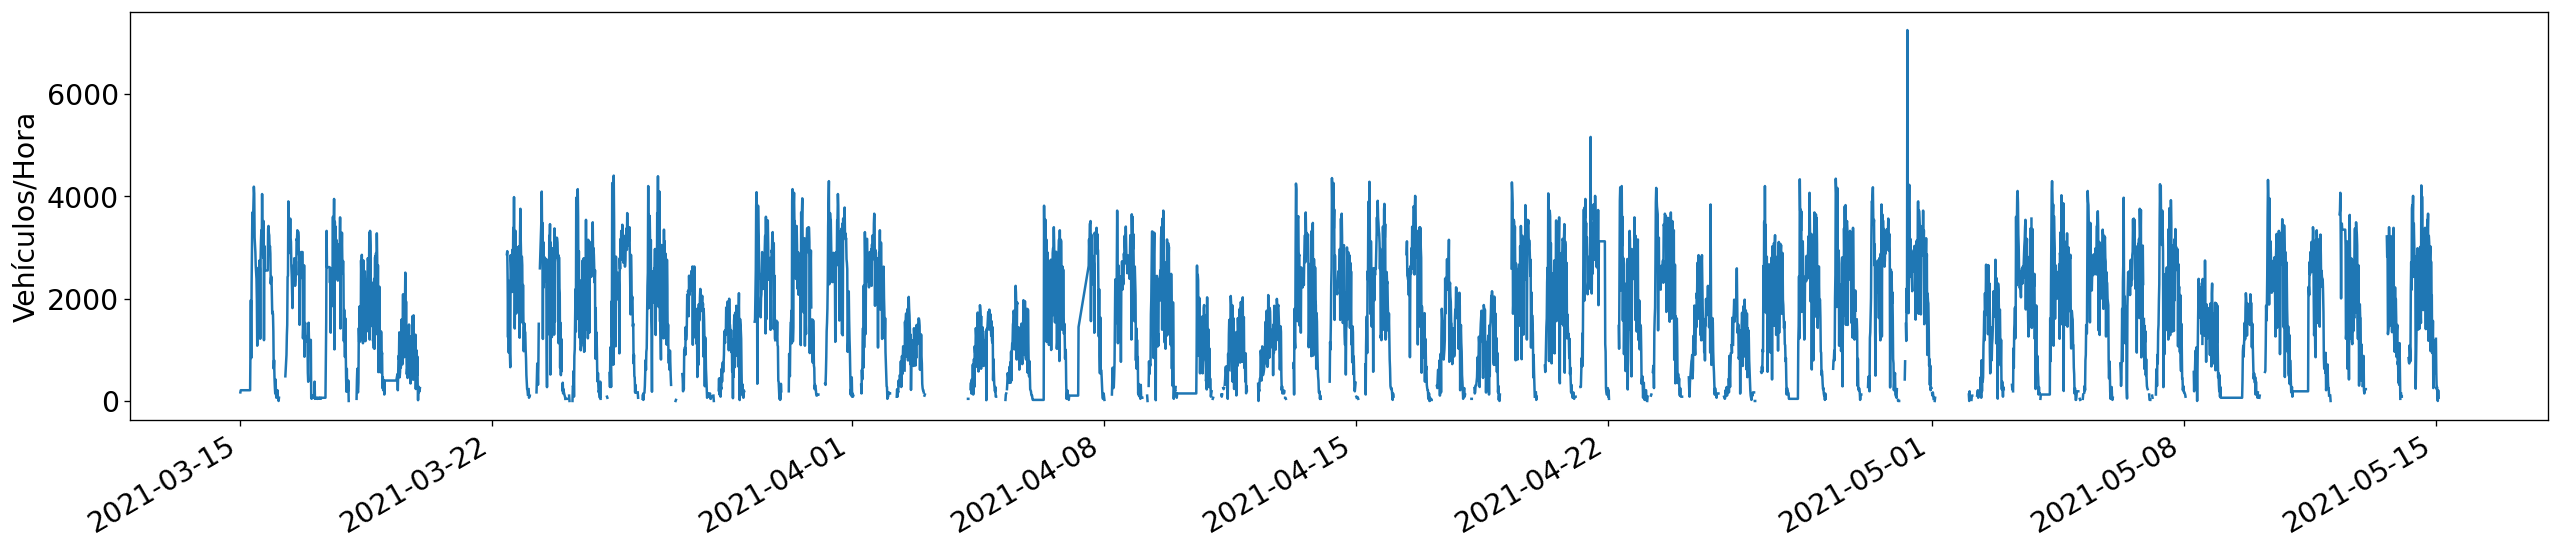

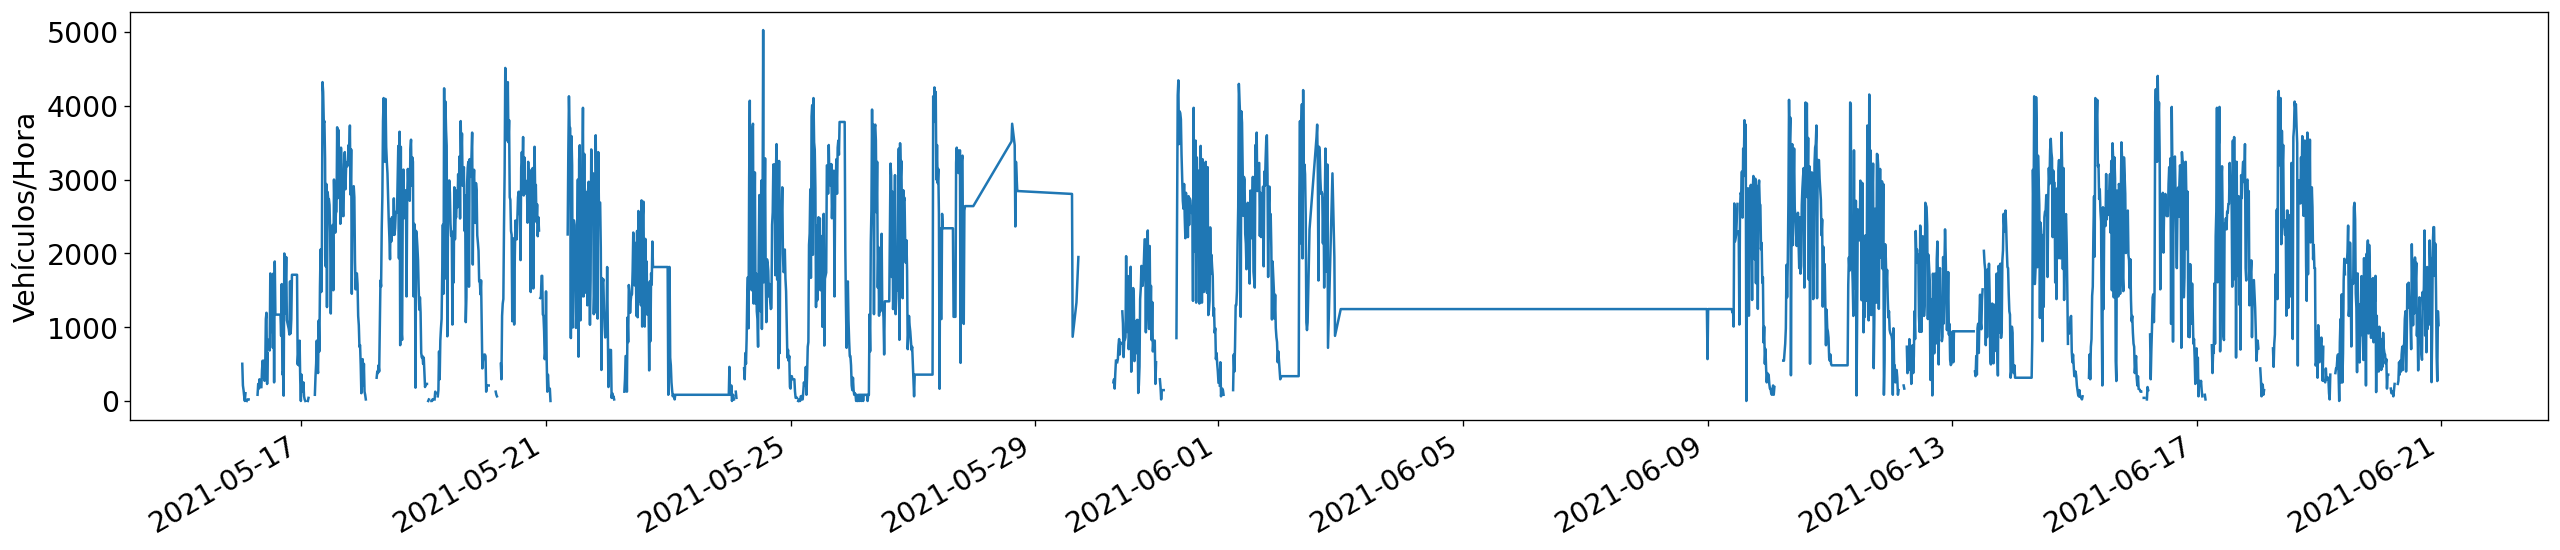

In [9]:
plot_series(data)

In [10]:
def clean_data(data):
  frames = []
  for fecha in fechas:
    elements = group.loc[fecha:fecha]
    elements.interpolate(method="linear", inplace=True)
    elements.ffill(inplace=True)
    elements.bfill(inplace=True)
    frames.append(elements)
  df = pd.concat(frames)
  return df

In [ ]:
indexed = new_df
indexed.set_index(pd.to_datetime(indexed.fecha.values), inplace=True)
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
groups = indexed.groupby(indexed.ATA)
frames = []

for name, group in groups:
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  group = clean_data(group)
  days = fechas
  frames.append(group)

data = pd.concat(frames)

data.set_index(pd.to_datetime(data.dates.values), inplace=True)
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)

                     ATA       barrio  ...               dates  coches
2021-03-15 00:00:00  A71  l olivereta  ... 2021-03-15 00:00:00   168.0
2021-03-15 00:15:00  A71  l olivereta  ... 2021-03-15 00:15:00   210.0
2021-03-15 00:30:00  A71  l olivereta  ... 2021-03-15 00:30:00   210.0
2021-03-15 00:45:00  A71  l olivereta  ... 2021-03-15 00:45:00   210.0
2021-03-15 01:00:00  A71  l olivereta  ... 2021-03-15 01:00:00   210.0
...                  ...          ...  ...                 ...     ...
2021-06-20 22:45:00  A71  l olivereta  ... 2021-06-20 22:45:00  1216.0
2021-06-20 23:00:00  A71  l olivereta  ... 2021-06-20 23:00:00  1027.0
2021-06-20 23:15:00  A71  l olivereta  ... 2021-06-20 23:15:00   546.0
2021-06-20 23:30:00  A71  l olivereta  ... 2021-06-20 23:30:00   482.0
2021-06-20 23:45:00  A71  l olivereta  ... 2021-06-20 23:45:00   693.0

[9029 rows x 15 columns]


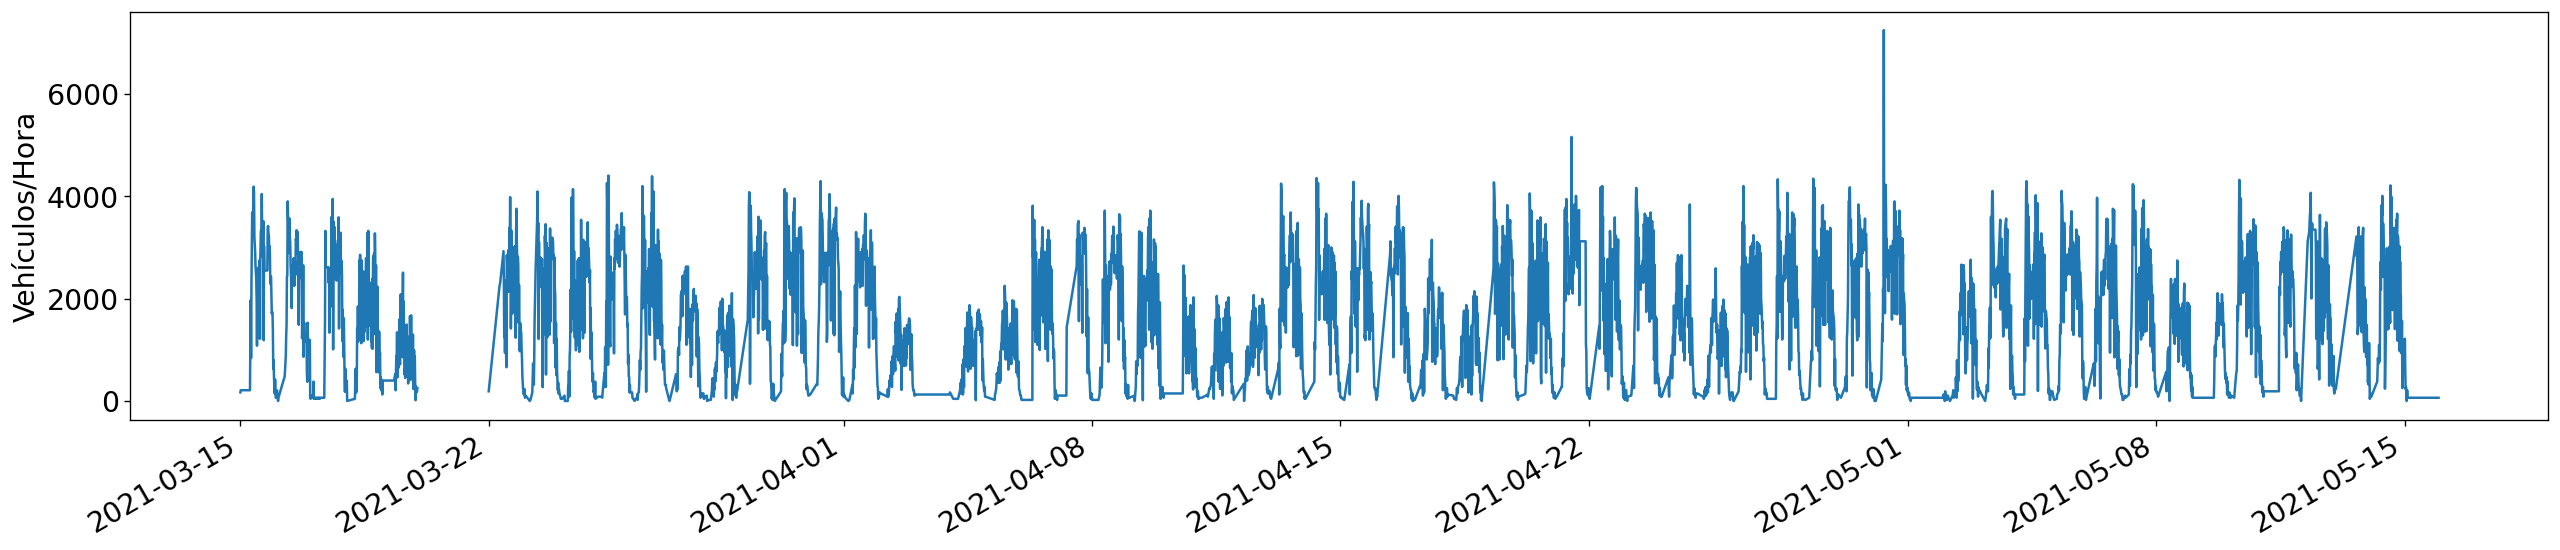

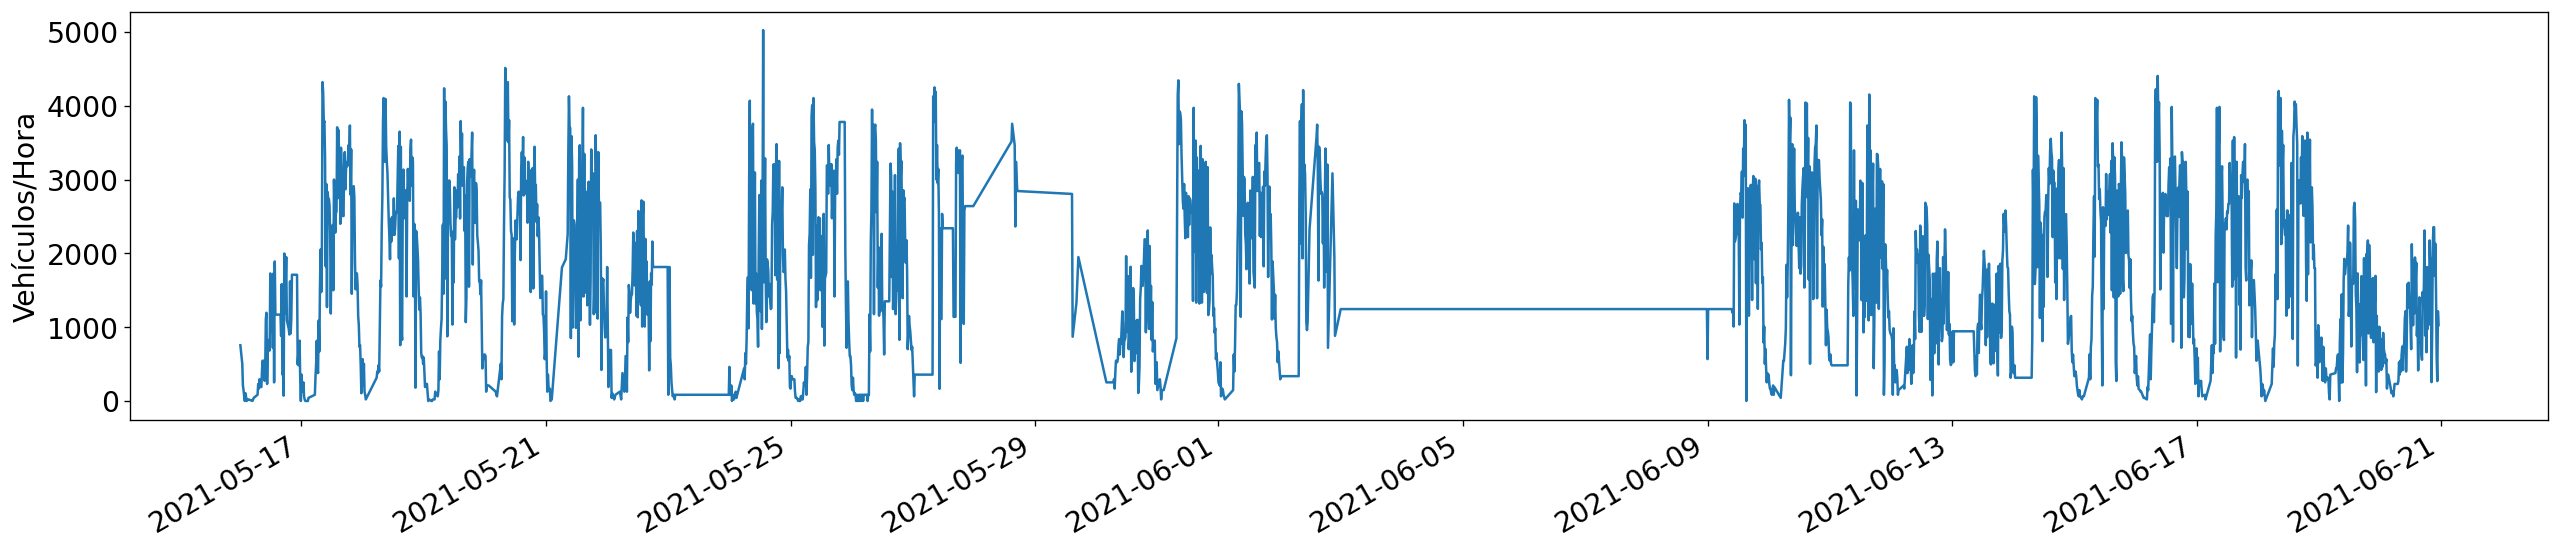

In [12]:
plot_series(data)

In [13]:
# Ordena por fecha y ATA
data.sort_values(['ATA', 'dates'], ascending=[True, True], inplace=True)
data.to_csv(test_clean_data_path)
dates_hours = list(set(data.dates.values))
# Listado de ATAS en el dataset
ATAS = list(set(data['ATA']))

In [14]:
# Transforma los datos 15minutales en datos horarios
def transform_data(df, to_csv):
  # Crea un dataframe diferente por cada ATA
  grouped = df.groupby(df.ATA)
  frames = []
  for ATA in ATAS:
    group = grouped.get_group(ATA)
    cars = group['coches']
    new_group = group.resample('H', on='dates', offset='1Hour').coches.mean()
    dates = new_group.keys()
    values = new_group.values
    group = group.drop('coches', axis=1)
    group = group.drop('dia', axis=1)
    group = group.drop('fecha', axis=1)
    group = group.drop('hora', axis=1)
    group = group.drop('dates', axis=1)
    keys = group.keys()
    group = pd.DataFrame(np.resize(group.values, (len(dates), len(group.keys()))))
    for i in range(len(values)):
      if (math.isnan(values[i])):
        values[i] = float("nan")
      else:
        values[i] = int(values[i])
    group['fechas'] = dates    
    # Al juntar por horas, descuadra los dias, volver a poner bien
    group['dia'] = group['fechas'].dt.day_name()
    group['coches'] = values
    for i in range(len(keys)):
      group = group.rename(columns={ i: str(keys[i])})
    frames.append(group)
  result = pd.concat(frames)
  if (to_csv):
    result.to_csv("ordenados.csv")
  return result
data = transform_data(data, True)

data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)

                     ATA       barrio  ...     dia  coches
2021-03-15 00:00:00  A71  l olivereta  ...  Monday   199.0
2021-03-15 01:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 02:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 03:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 04:00:00  A71  l olivereta  ...  Monday   210.0
...                  ...          ...  ...     ...     ...
2021-06-20 19:00:00  A71  l olivereta  ...  Sunday  1593.0
2021-06-20 20:00:00  A71  l olivereta  ...  Sunday  1316.0
2021-06-20 21:00:00  A71  l olivereta  ...  Sunday  2133.0
2021-06-20 22:00:00  A71  l olivereta  ...  Sunday   892.0
2021-06-20 23:00:00  A71  l olivereta  ...  Sunday   687.0

[2352 rows x 13 columns]


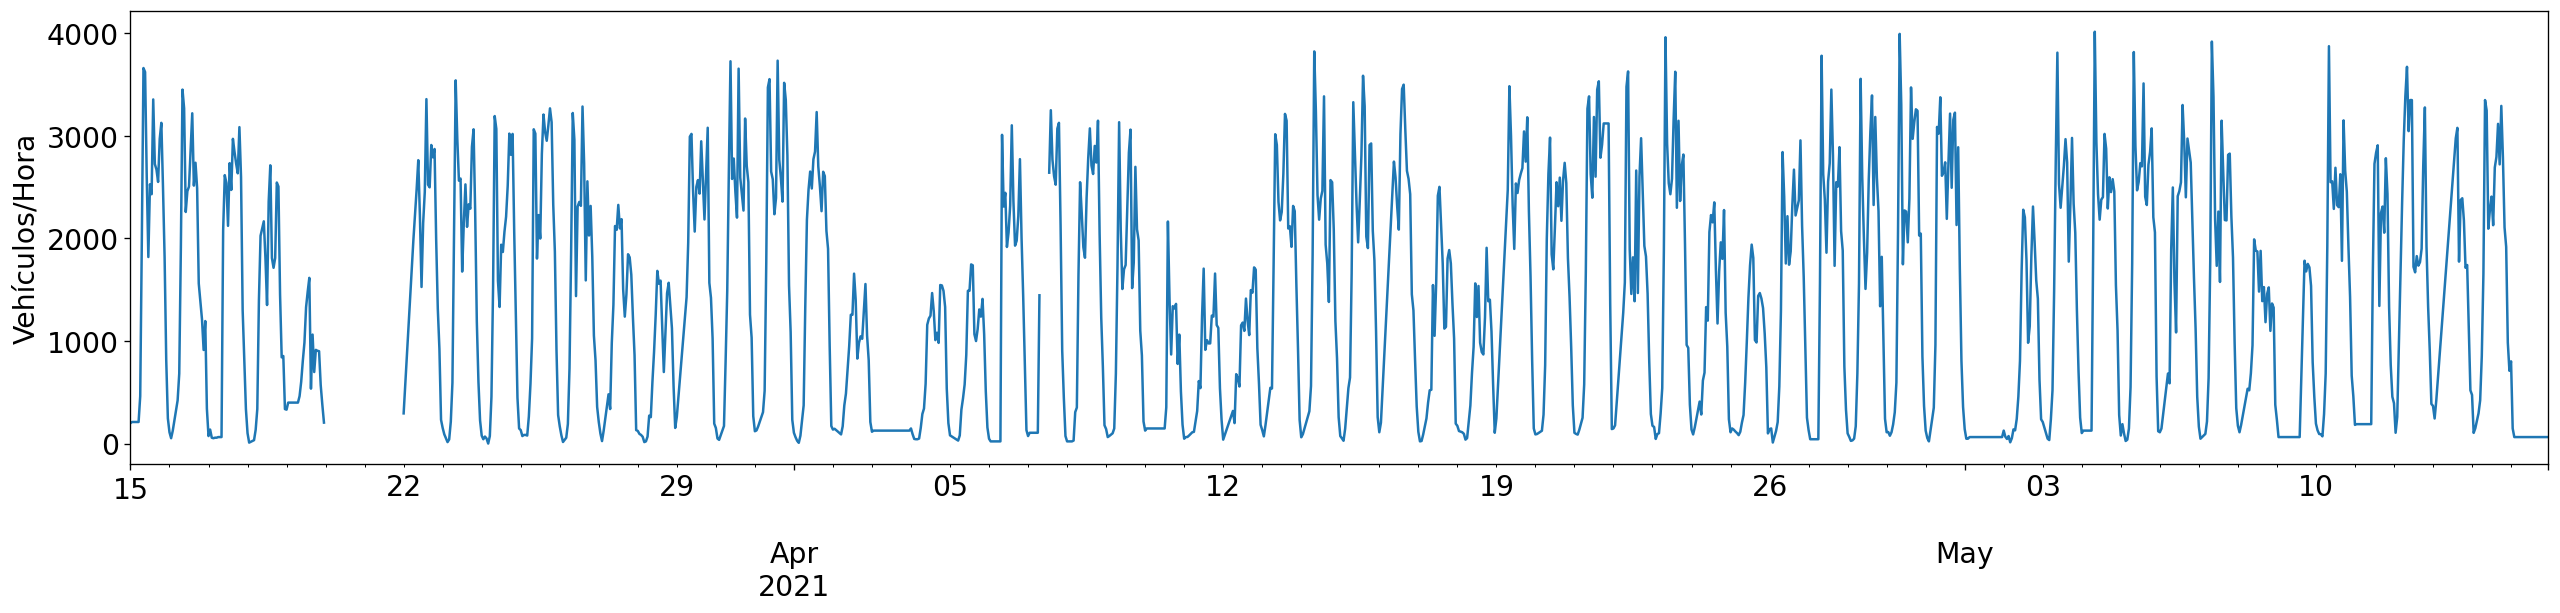

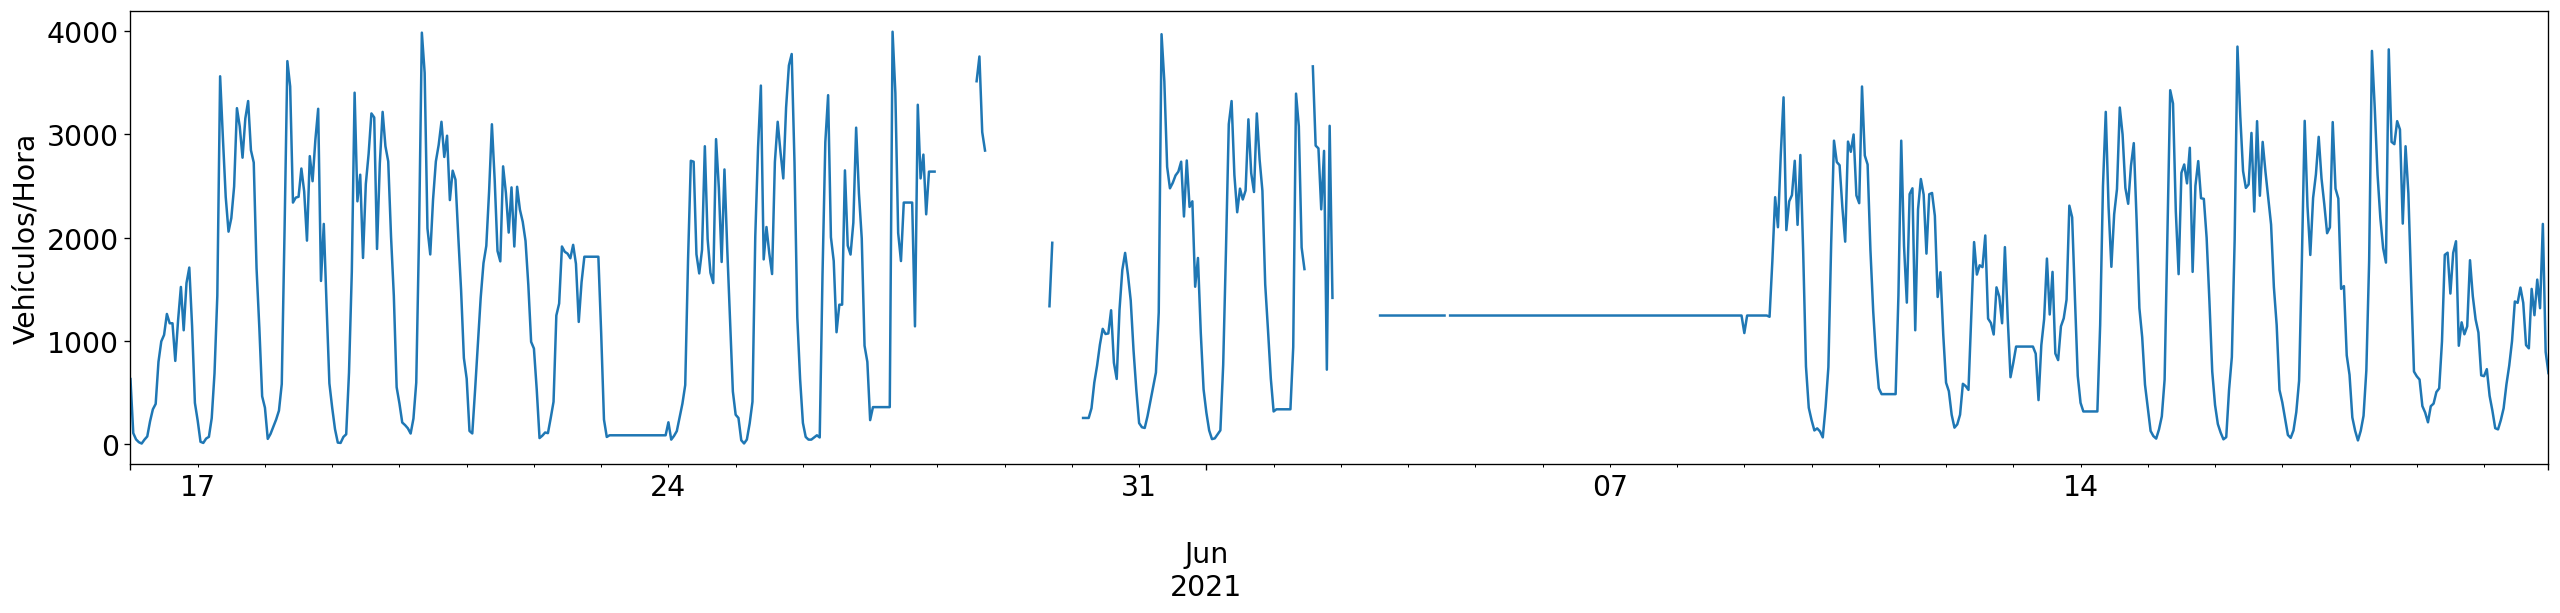

In [15]:
plot_series(data)

In [ ]:
groups = data.groupby(data.ATA)
frames = []
# fechas = data.fechas.values
for name, group in groups:
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  group = clean_data(group)
  days = fechas
  frames.append(group)

data = pd.concat(frames)

data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)

                     ATA       barrio  ...     dia  coches
2021-03-15 00:00:00  A71  l olivereta  ...  Monday   199.0
2021-03-15 01:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 02:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 03:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 04:00:00  A71  l olivereta  ...  Monday   210.0
...                  ...          ...  ...     ...     ...
2021-06-20 19:00:00  A71  l olivereta  ...  Sunday  1593.0
2021-06-20 20:00:00  A71  l olivereta  ...  Sunday  1316.0
2021-06-20 21:00:00  A71  l olivereta  ...  Sunday  2133.0
2021-06-20 22:00:00  A71  l olivereta  ...  Sunday   892.0
2021-06-20 23:00:00  A71  l olivereta  ...  Sunday   687.0

[2352 rows x 13 columns]


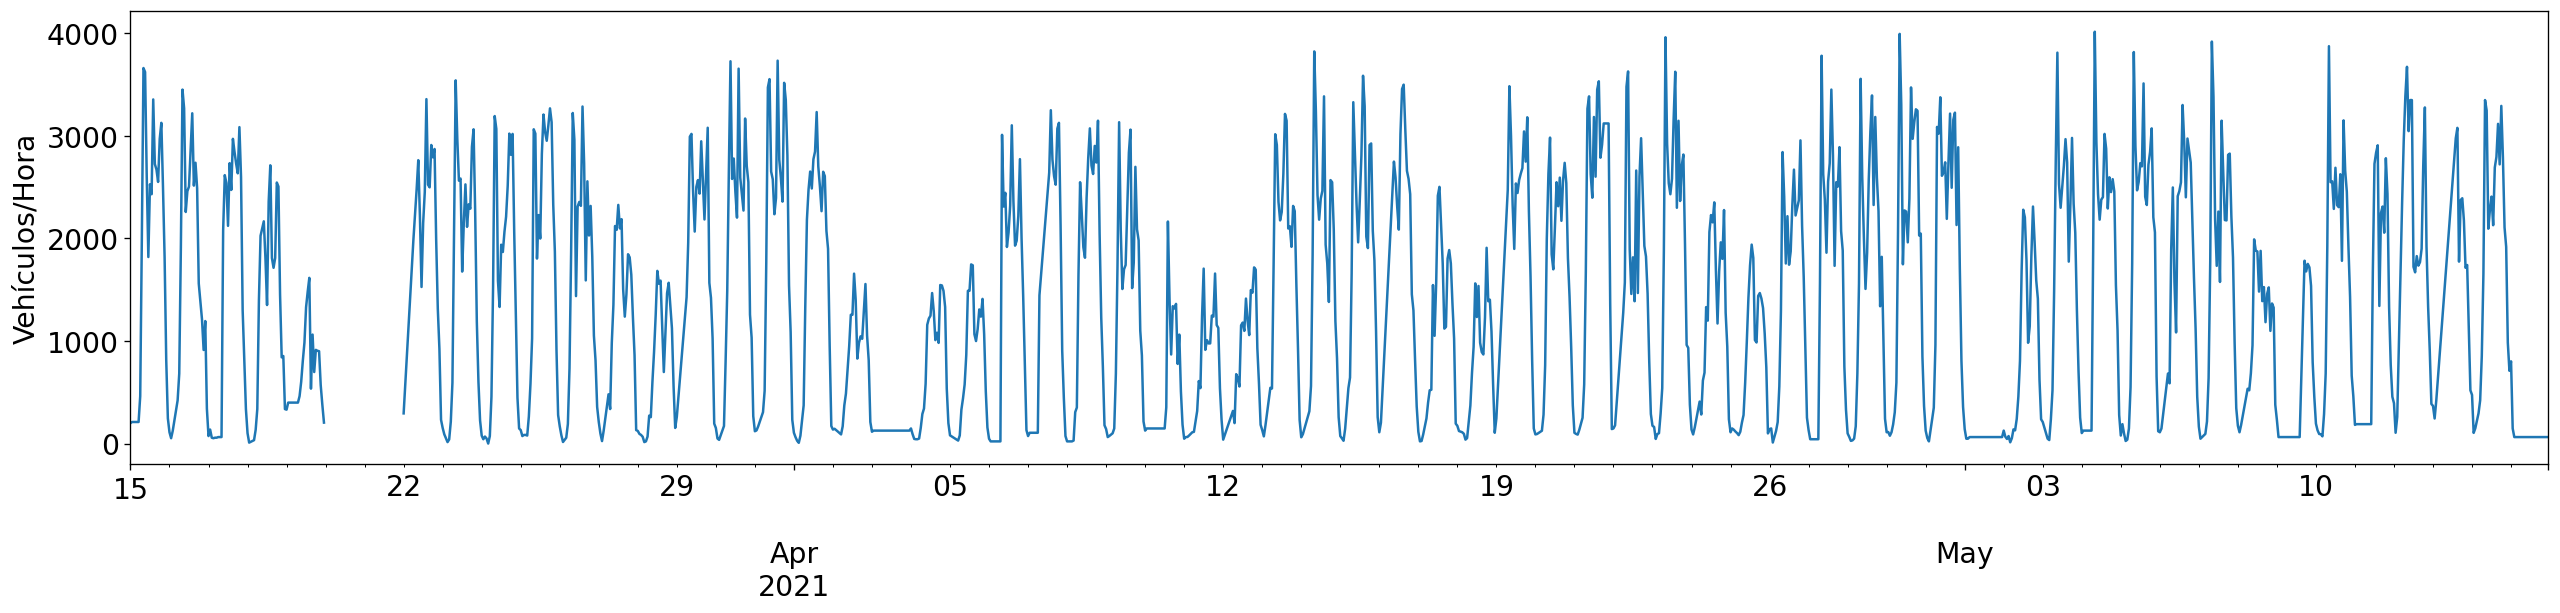

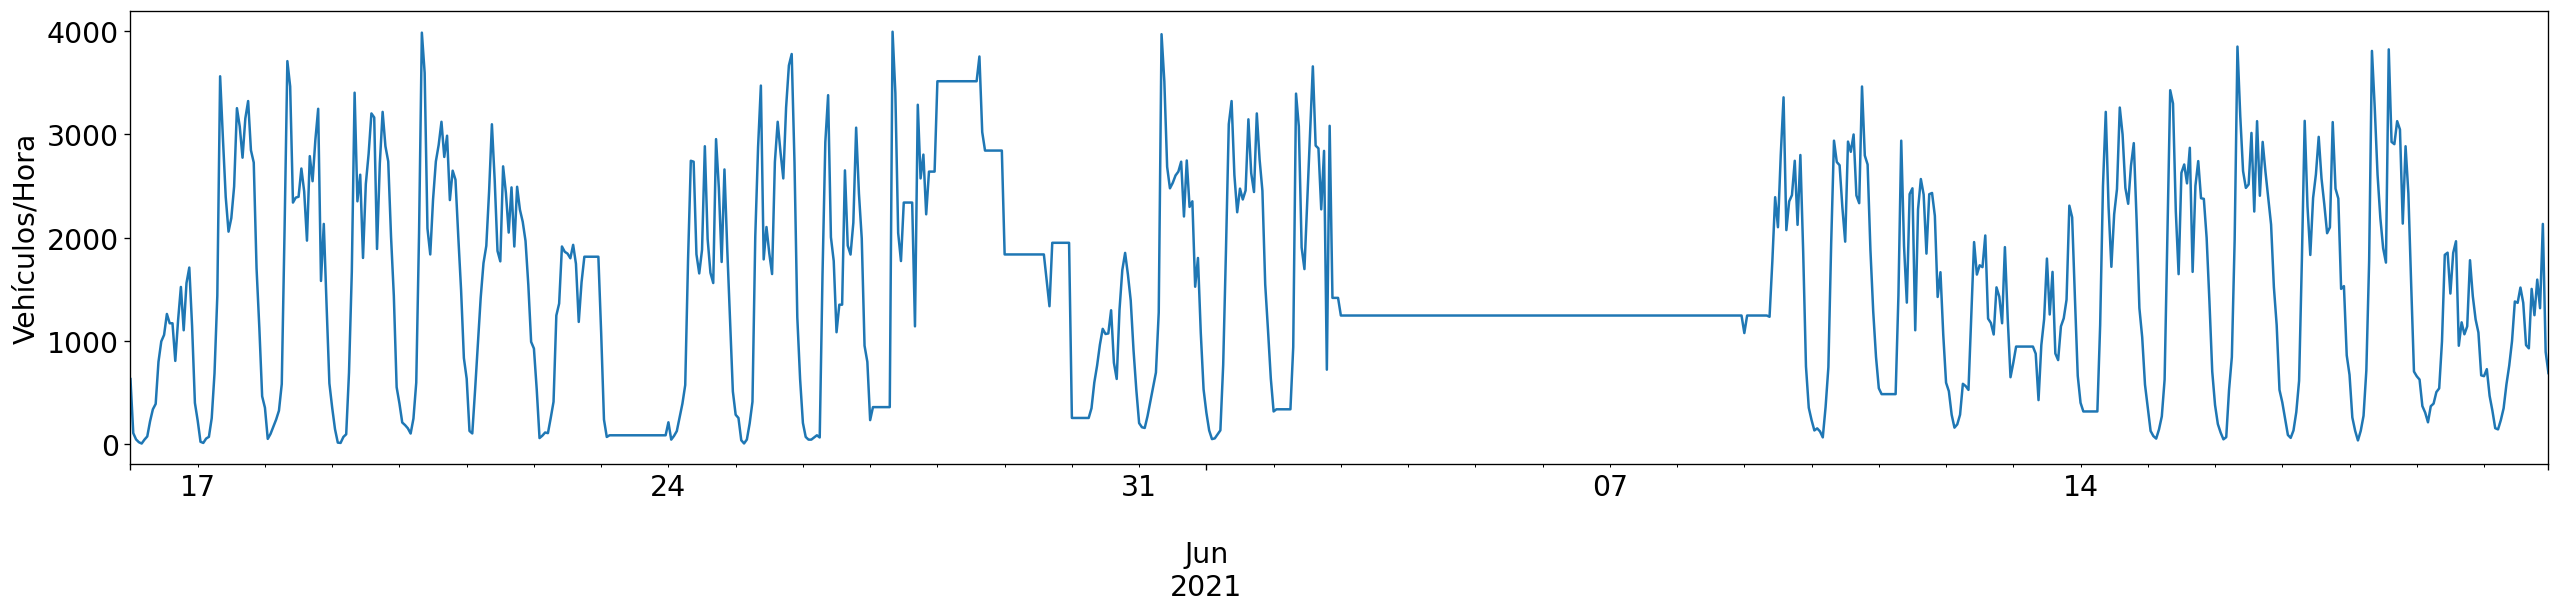

In [17]:
plot_series(data)

In [18]:
def clean_empty_data(data, fill=False):
  frames = []
  for i in range(len(fechas)):
    elements = group.loc[fechas[i]:fechas[i]]
    if elements.coches.isna().sum() > 12:
      if elements.ATA.isna().sum() > 0:
        pass
      if (i > 6):
        coches = frames[i-7].coches
        elements = elements.drop('coches', axis=1)
        elements.insert(len(elements.columns), 'coches', coches)
      else:
        coches = group.loc[fechas[i+7]:fechas[i+7]].coches.values
        elements = elements.drop('coches', axis=1)
        elements.insert(len(elements.columns), 'coches', coches)
    frames.append(elements)
  df = pd.concat(frames)
  return df

In [19]:
groups = data.groupby(data.ATA)
frames = []
for name, group in groups:
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  group = clean_empty_data(group)
  days = fechas
  frames.append(group)

data = pd.concat(frames)
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)

                     ATA       barrio  ...     dia  coches
2021-03-15 00:00:00  A71  l olivereta  ...  Monday   199.0
2021-03-15 01:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 02:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 03:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 04:00:00  A71  l olivereta  ...  Monday   210.0
...                  ...          ...  ...     ...     ...
2021-06-20 19:00:00  A71  l olivereta  ...  Sunday  1593.0
2021-06-20 20:00:00  A71  l olivereta  ...  Sunday  1316.0
2021-06-20 21:00:00  A71  l olivereta  ...  Sunday  2133.0
2021-06-20 22:00:00  A71  l olivereta  ...  Sunday   892.0
2021-06-20 23:00:00  A71  l olivereta  ...  Sunday   687.0

[2352 rows x 13 columns]


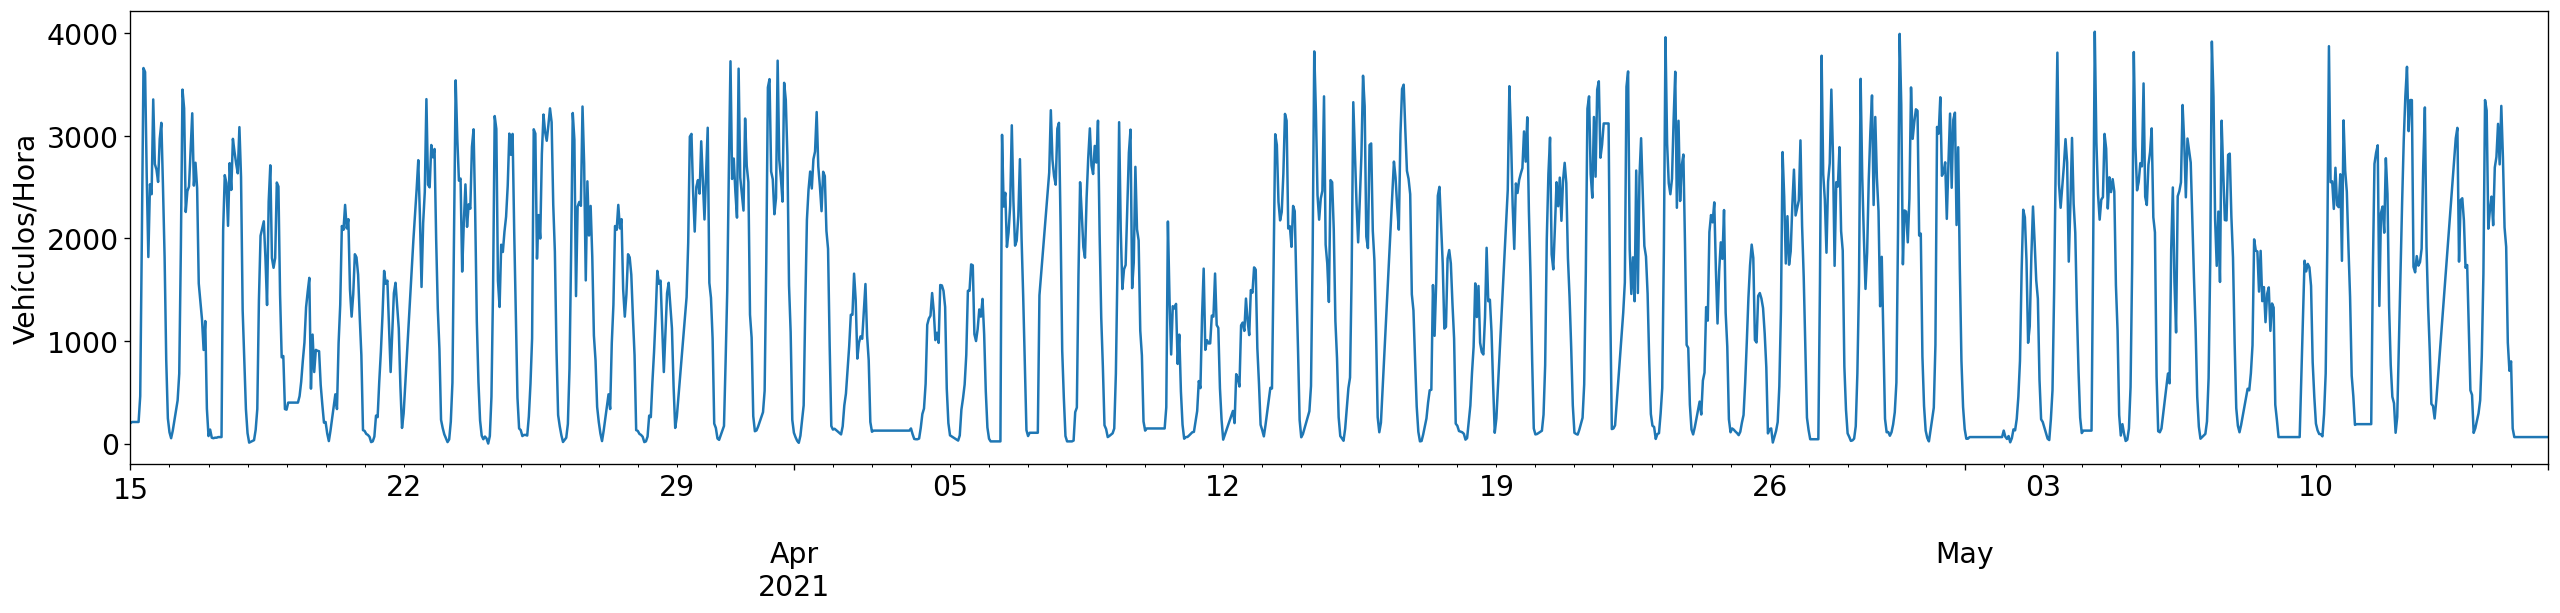

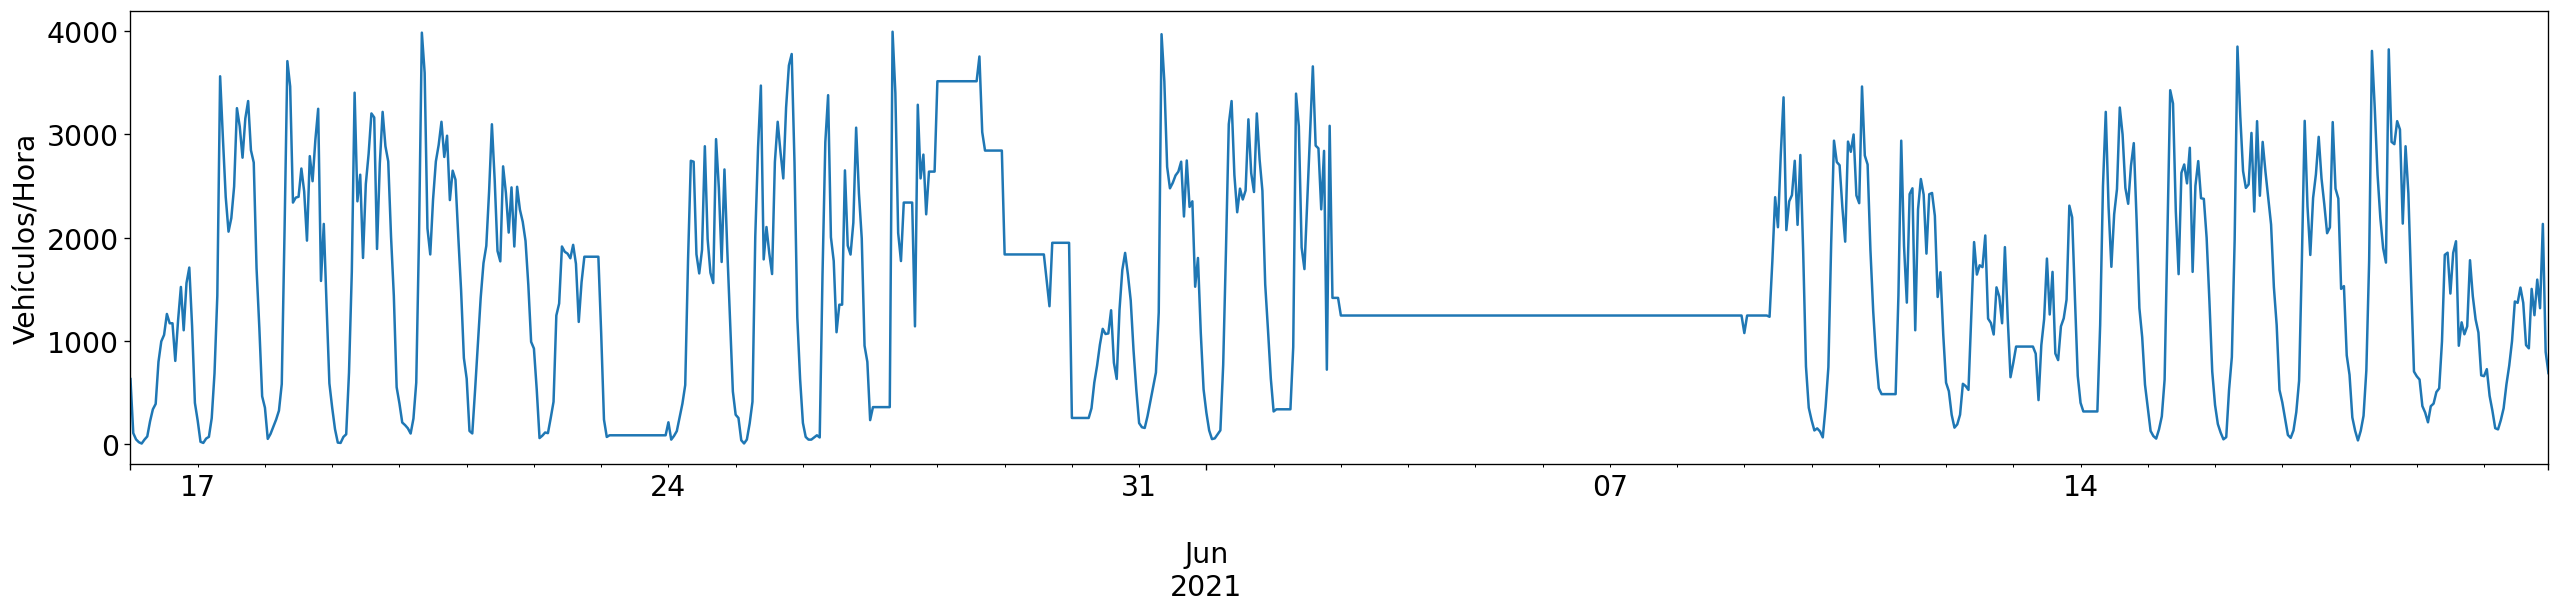

In [20]:
plot_series(data)

In [21]:
def clean_repeated_data(data):
  frames = []
  count = 0
  for i in range(len(fechas)):
    elements = group.loc[fechas[i]:fechas[i]]
    vals = elements.coches.values
    elems = len(list(set((vals))))
    # Si hay 19 lecturas iguales, se considera error
    if elems < 5:
      if (i > 6):
        count += 1
        prev = frames[i-7]
        cars = prev["coches"].values
        elements.drop("coches", axis=1, inplace=True)
        elements["coches"] = cars
      else:
        cars = group.loc[fechas[i+7]:fechas[i+7]].coches.values
        elements.drop("coches", axis=1, inplace=True)
        elements["coches"] = cars
    frames.append(elements)
  df = pd.concat(frames)
  return df

data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)


In [ ]:
groups = data.groupby(data.ATA)
frames = []
for name, group in groups:
  group = group.loc["2021-03-01 00:00:00":"2021-06-30 23:00:00"]
  group = clean_repeated_data(group)
  days = fechas
  frames.append(group)

data = pd.concat(frames)
data.set_index(pd.to_datetime(data.fechas.values), inplace=True)
data.sort_values(['ATA', 'fechas'], ascending=[True, True], inplace=True)


                     ATA       barrio  ...     dia  coches
2021-03-15 00:00:00  A71  l olivereta  ...  Monday   199.0
2021-03-15 01:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 02:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 03:00:00  A71  l olivereta  ...  Monday   210.0
2021-03-15 04:00:00  A71  l olivereta  ...  Monday   210.0
...                  ...          ...  ...     ...     ...
2021-06-20 19:00:00  A71  l olivereta  ...  Sunday  1593.0
2021-06-20 20:00:00  A71  l olivereta  ...  Sunday  1316.0
2021-06-20 21:00:00  A71  l olivereta  ...  Sunday  2133.0
2021-06-20 22:00:00  A71  l olivereta  ...  Sunday   892.0
2021-06-20 23:00:00  A71  l olivereta  ...  Sunday   687.0

[2352 rows x 13 columns]


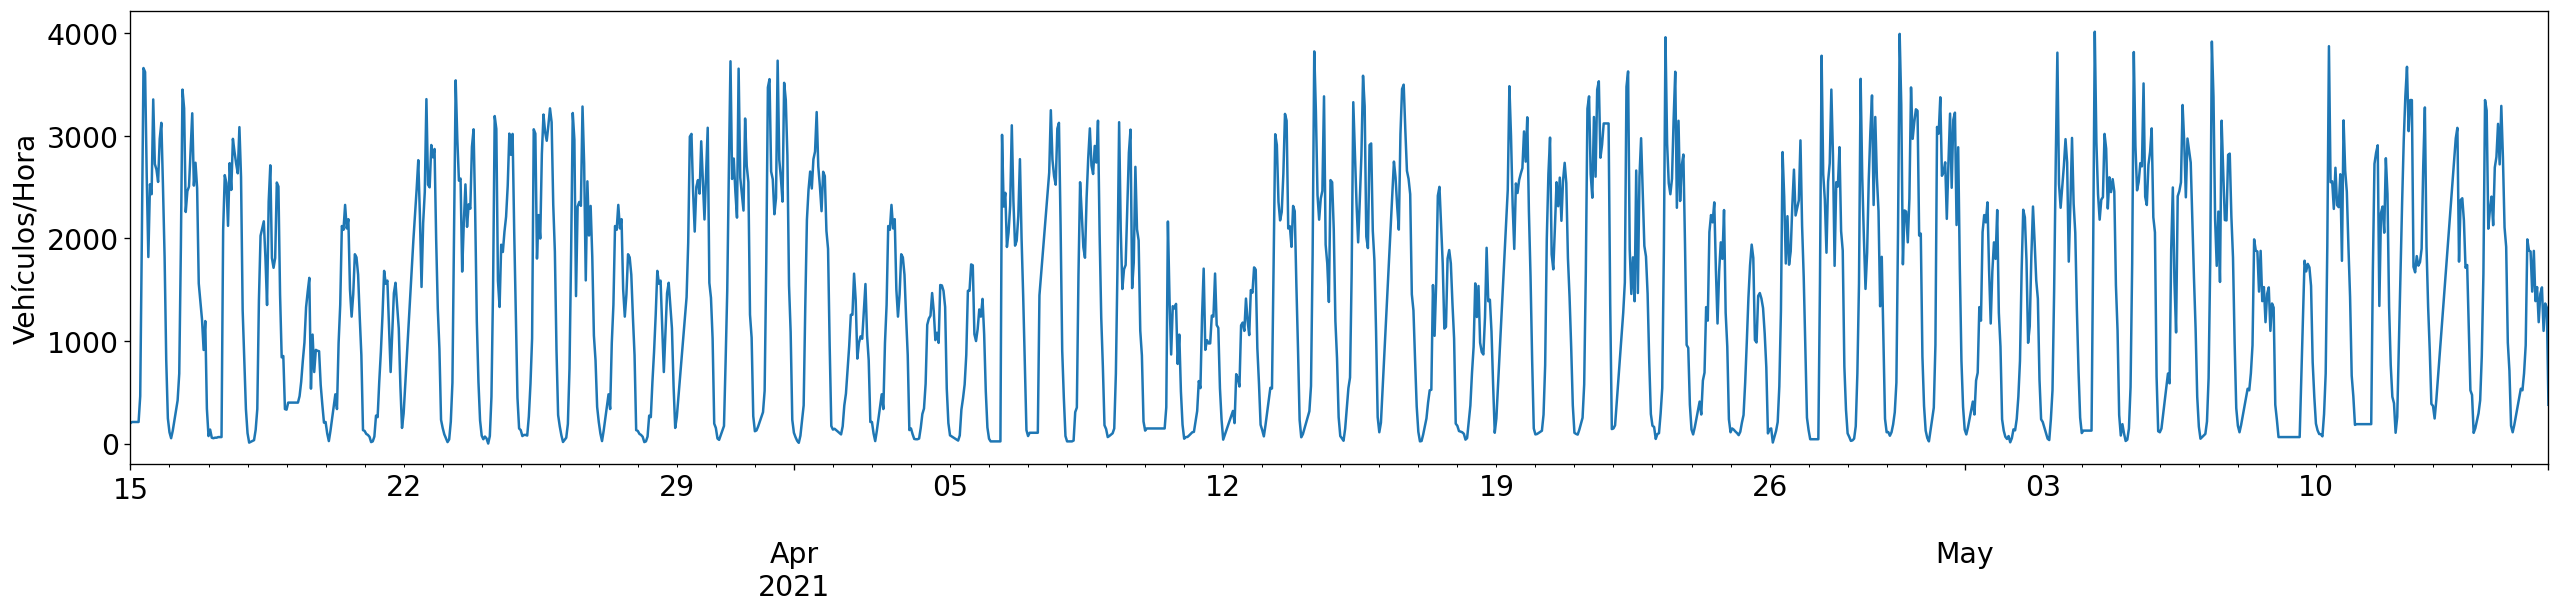

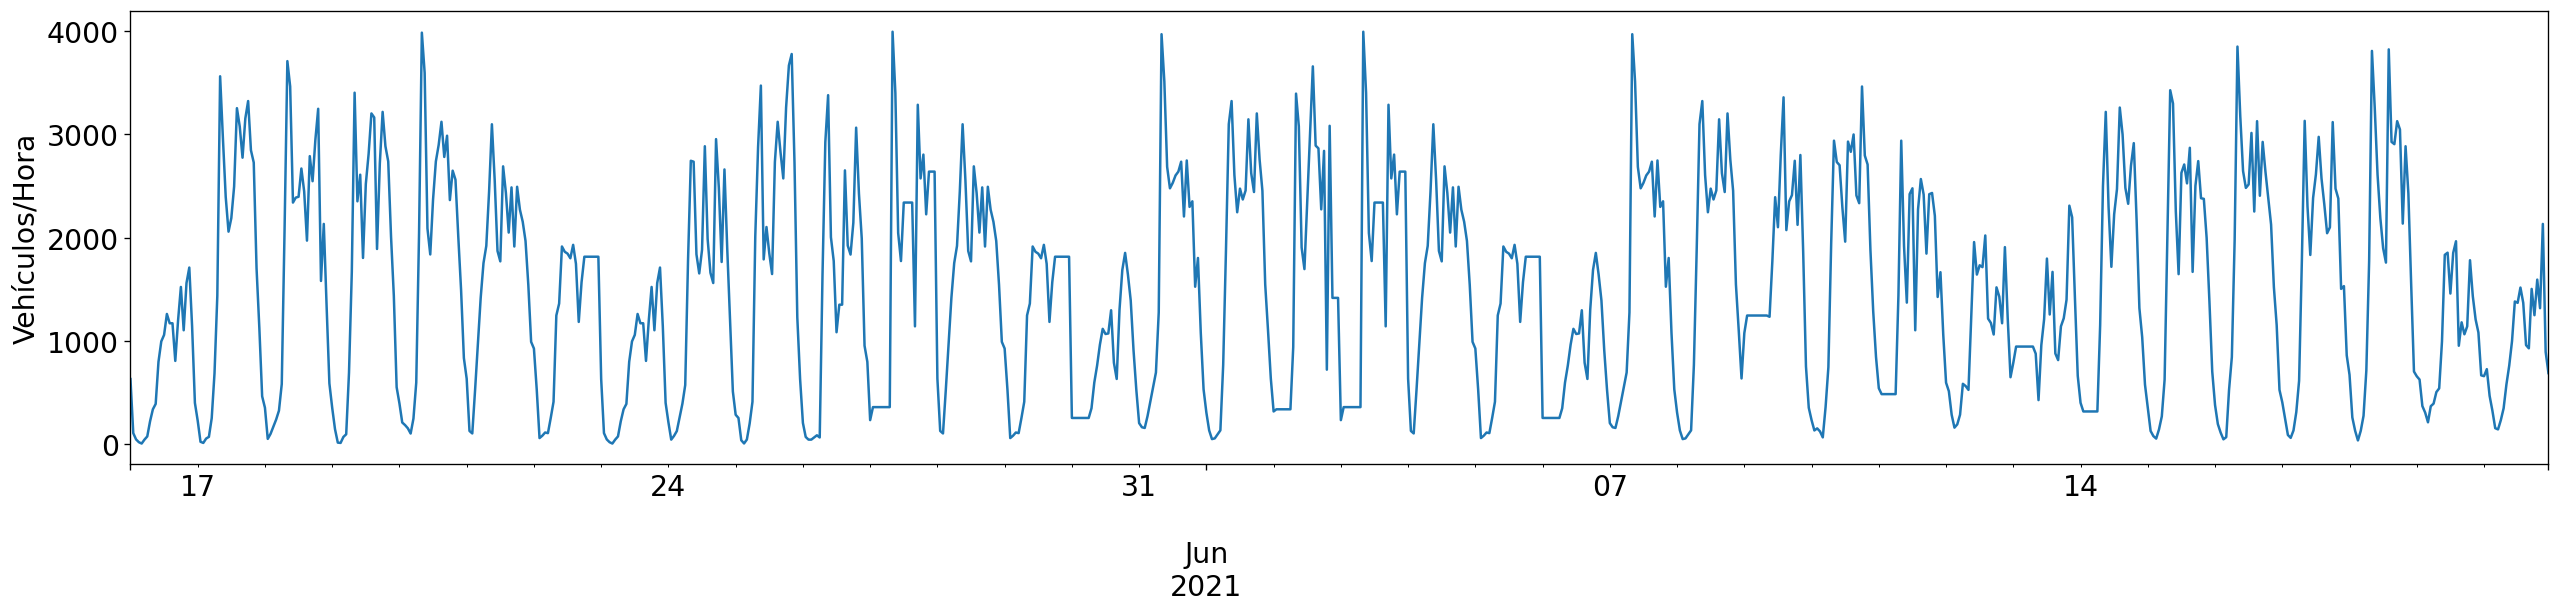

In [23]:
plot_series(data)

In [24]:
data.to_csv(to_show)
data.dropna(inplace=True)

In [25]:
data.to_csv(ordered_data_path)

In [ ]:
ordered = pd.read_csv(to_show)
ordered.drop("Unnamed: 0", axis=1, inplace=True)
print(ordered)

In [27]:
grouped = ordered.groupby(ordered.ATA)

In [28]:
dates = list(set(list(ordered['fechas'])))
final_df = pd.DataFrame(index=pd.to_datetime(dates))
keys = []
for name, group in grouped:
  # coches = pd.DataFrame(group['coches'].values, index=group['fechas'])
  temp = pd.DataFrame(group['coches'].values, index = pd.to_datetime(group['fechas']))
  # if group["ATA"].iloc[0] == "A52":
  keys.append(group["ATA"].iloc[0])
  final_df = pd.concat([final_df, temp], axis=1)
final_df.sort_index(ascending=True, inplace=True)
final_df.columns = keys


In [ ]:
final_df

In [30]:
final_df.to_csv(to_show)